# Imports

In [38]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [79]:
data_path = '~/../../media/sf_data/'
file_name = 'seti_breakthrough_listen_et'
data_path = data_path + file_name

In [89]:
TARGET = 'target'

In [80]:
def get_train_file_path(image_id):
    return f"{data_path}/train/{image_id[0]}/{image_id}.npy"

def get_test_file_path(image_id):
    return f"{data_path}/test/{image_id[0]}/{image_id}.npy"

In [81]:
train = pd.read_csv(data_path + '/train_labels.csv')
train['file_path'] = train['id'].apply(get_train_file_path)
train['file_path'] = train['file_path'].str.split('~/../..').str[-1]

test = pd.read_csv(data_path + '/sample_submission.csv')
test['file_path'] = test['id'].apply(get_test_file_path)
test['file_path'] = test['file_path'].str.split('~/../..').str[-1]

In [82]:
tmp = train.query('target==1')
tmp['folder'] = tmp['id'].str[0]
tmp.groupby('folder')['folder'].count().sort_values(ascending=False)

/home/jeris/src/kaggle-competitions/env/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


folder
f    312
3    310
6    306
c    305
5    302
8    301
0    294
9    293
e    293
7    291
a    286
2    283
4    283
b    281
1    278
d    276
Name: folder, dtype: int64

In [85]:
train.head()

,id,target,file_path
0,00034abb3629,0,/media/sf_data/seti_breakthrough_listen_et/train/0/00034abb3629.npy
1,0004300a0b9b,0,/media/sf_data/seti_breakthrough_listen_et/train/0/0004300a0b9b.npy
2,000453852fda,0,/media/sf_data/seti_breakthrough_listen_et/train/0/000453852fda.npy
3,00047dfc96a9,0,/media/sf_data/seti_breakthrough_listen_et/train/0/00047dfc96a9.npy
4,0004be0baf70,0,/media/sf_data/seti_breakthrough_listen_et/train/0/0004be0baf70.npy


# EDA

<AxesSubplot:>

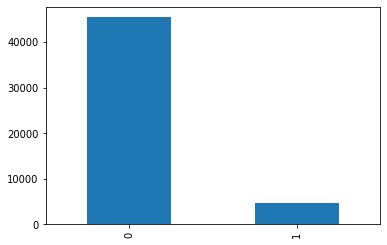

In [93]:
train[TARGET].value_counts().plot(kind='bar')

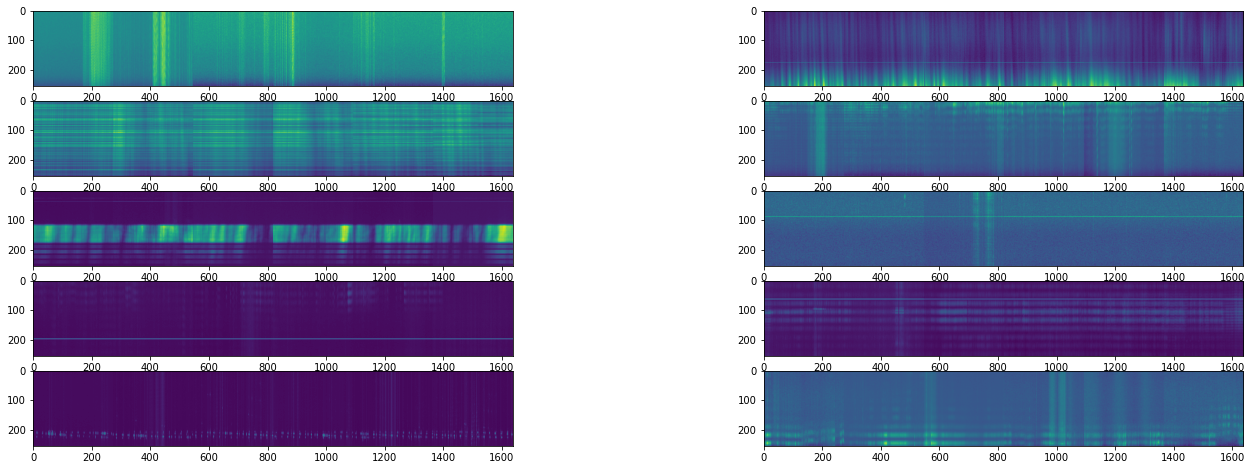

In [94]:
plt.figure(figsize=(24,8))
for i in range(10):
    raw = np.load(train.loc[i,'file_path'])
    image = np.load(train.loc[i,'file_path'])
    image = image.astype(np.float32)
    image = np.vstack(image).transpose((1, 0)) # (1638, 256) -> (256, 1638)
    plt.subplot(5, 2, i + 1)
    plt.imshow(image)
plt.show()

In [96]:
raw.shape

(6, 273, 256)

In [98]:
raw[0].shape

(273, 256)